<div align="center">
    <h1><b>Reinforcement Learning Assignment</b></h1>
</div>

## Introduction
This notebook is part of an assignment for the course **'Reinforcement Learning & Stochastic Games'** of the **[Department of Informatics and Telecommunications](https://www.di.uoa.gr/)** at the **National and Kapodistrian University of Athens (NKUA)**.

### Purpose
The purpose of this assignment is to **experiment** with various **machine learning algorithms**, in order to train a model on a specific **environment** from **[OpenAI Gym or Gymnasium](https://www.gymlibrary.dev/index.html)**.

### Team Members
The members who contributed to this assignment are as follows:

| First Name | Last Name | Student ID | Email |
| :---: | :---: | :---: | :---: |
| Antonis | Zikas | 1115202100038 | sdi2100038@di.uoa.gr |
| Panagiotis | Papapostolou | 1115202100142 | sdi2100142@di.uoa.gr |

## Environment Selection and Analysis
In this assignment, we chose to work with the **[CartPole-v1](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)** environment, which belongs to the **[Classic Control](https://www.gymlibrary.dev/environments/classic_control/)** category.

<div align="center">
<img src="../assets/imgs/cart-pole-diagram.png" width="500px">    
</div>

Let's analyze this environment.

### Action Space
For this specific environment, there are **two possible actions**. Specifically, the **cart** can move either **left** or **right**. These actions are represented by **0** and **1** respectively and are described in the table below:

| Number | Action |
| :---: | :---: |
| 0 | Move left |
| 1 | Move right |

Therefore, the **action** of this environment is an `ndarray` of shape `(1,)` and can take two values `{0, 1}`.

### Observation Space
The **observation space** for this environment is a collection of **4** values:
1. The **position** of the cart **(Cart Position)**
2. The **velocity** of the cart **(Cart Velocity)**
3. The **angle** formed by the pole with the vertical axis **(Pole Angle)**
4. The **angular velocity** of the pole as it falls **(Pole Angular Velocity)**

These values are stored in an `ndarray` of shape `(4,)` and each value has specific limits, described below:

| Array index | Observation | Min Value | Max Value |
| :---: | :---: | :---: | :---: |
| 0 | Cart Position | $-4.8$ | $4.8$ |
| 1 | Cart Velocity | $-\infty$ | $+\infty$ |
| 2 | Pole Angle | ~ $-0.418$ rad (-$24^{\circ}$) | ~ $0.418$ rad ($24^{\circ}$) |
| 3 | Pole Angular Velocity | $-\infty$ | $+\infty$ |

### Reward
For each step during the training of the model, the **reward** received by the selected **agent** is `+1`, including the **termination step**. The **reward threshold** for this environment is **500**.

## Environment Default Run

### Loading the environment

In [18]:
import gymnasium as gym

env = gym.make('CartPole-v1')
observations = env.observation_space.shape[0]
actions = env.action_space.n

print(f"Observations: {observations}, Actions: {actions}")
env.close()

Observations: 4, Actions: 2


As we observe from the above code execution, the **observations** and **actions** are indeed **4** and **2** respectively. Let’s try running this environment **without** any trained model and observe the results.

### Running

In [19]:
# Define the number of epochs and initialize scores
epochs = 200
epochs_scores = []
wins, fails = 0, 0

# Run the environment for the specified number of epochs
env = gym.make('CartPole-v1')
for epoch in range(1, epochs+1):
    env.reset()
    done = False
    score, total_steps = 0, 0
    
    while not done:
        action = env.action_space.sample() # Chose a random action from 0 and 1
        observation, reward, terminated, truncated, _ = env.step(action)
        score += reward
        total_steps += 1
        
        # Check if the episode is done, either by termination or truncation
        if terminated or truncated:
            observation, _ = env.reset()
            done = True

            # Count wins and fails based on the episode outcome
            if terminated and total_steps < epochs:
                fails += 1
            else:
                wins +=1
    
    epochs_scores.append(score)

env.close()
default_scores = epochs_scores
default_wins, default_fails = wins, fails

### Visualizing the results
Let’s visualize the total **score** achieved by our environment for each **epoch**, as well as the number of successes and failures recorded.

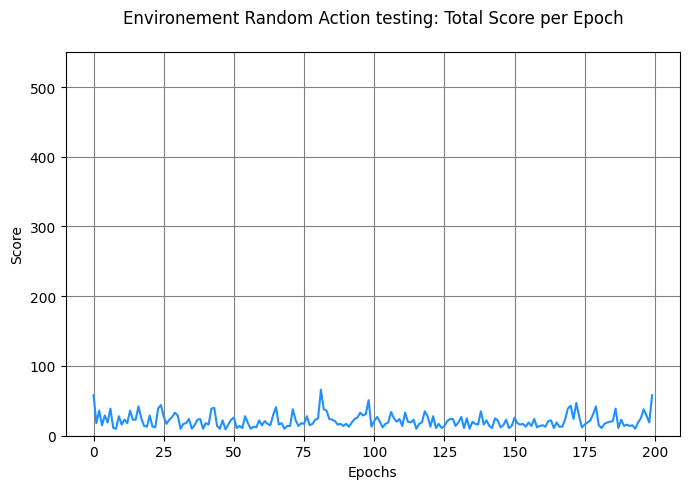

Number of wins: 0
Number of fails: 200


In [20]:
import matplotlib.pyplot as plt

plt.style.use('default')
plots_save_path = '../reports/figs/'

figure, axis = plt.subplots(1, 1, figsize=(7, 5))
axis.plot(epochs_scores, color='dodgerblue')
axis.set_ylim(0, 550)
axis.set_title("Environement Random Action testing: Total Score per Epoch\n")
axis.set_xlabel("Epochs")
axis.set_ylabel("Score")
axis.grid(color='grey')

plt.tight_layout()
plt.savefig(plots_save_path + 'default_scores.png')
plt.show()

print(f'Number of wins: {default_wins}')
print(f'Number of fails: {default_fails}')

From the above diagram, we observe that the total **score** achieved by the environment is very low. Our goal, therefore, is to **train** a model so that we manage to increase the **score** up to the corresponding **threshold** of the environment, which is **500**.

## Implementation of the DQN (Deep Q-Network) Algorithm

We will start by implementing the **[DQN](https://medium.com/@samina.amin/deep-q-learning-dqn-71c109586bae)** algorithm, which will be used to train our model. This algorithm requires the use of a **neural network**, for which we will use the **[PyTorch](https://pytorch.org/)** package.

<!-- <div align="center">
    <img src="https://miro.medium.com/v2/resize:fit:2400/format:webp/1*aqNgmfyBIStLrf9k7d9cng.jpeg" width="500px">
</div> -->

### Connect to device

In [21]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Pytorch connected to {device}')

Pytorch connected to cuda


### Setting random seed

In [22]:
import random
import torch
import numpy as np
import os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        try:
            torch.use_deterministic_algorithms(False)
        except RuntimeError:
            print("Warning: Could not enable deterministic algorithms in torch.")

        os.environ['PYTHONHASHSEED'] = str(seed)

### Building the Neural Network
Let’s start with building the **neural network**. The **architecture** of the network will be as follows:
1. **Input Layer** with **4 nodes** (number of observations)
2. **Hidden Layer 1** with **128 nodes**
3. **Hidden Layer 2** with **128 nodes**
4. **Output Layer** with **2 nodes** (number of actions)

In [23]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F


class DeepQNetwork_CartPole(nn.Module):
    def __init__(self, input_dims: int, output_dims: int) -> None:
        super(DeepQNetwork_CartPole, self).__init__()
        self.input_dims = input_dims
        self.output_dims = output_dims

        self.fc1 = nn.Linear(self.input_dims, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, self.output_dims)
          

    def forward(self, state: T.Tensor) -> T.Tensor:
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        actions = self.fc4(x)

        return actions


### Creating the Replay Buffer

In [24]:
import numpy as np
from collections import deque
import torch as T


class ReplayBufferMemory:
    def __init__(self, capacity=10000, device='cpu'):
        self.device = device
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = np.random.choice(len(self.memory), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.memory[i] for i in batch])
        return (
            T.Tensor(np.array(states)).to(self.device),
            T.LongTensor(np.array(actions)).to(self.device),
            T.Tensor(np.array(rewards)).to(self.device),
            T.Tensor(np.array(next_states)).to(self.device),
            T.Tensor(np.array(dones)).to(self.device)
        )
    
    def __len__(self):
        return len(self.memory)


### Implementing the Agent

In [25]:
import torch as T
import torch.nn as nn
import numpy as np


class Agent():
    def __init__(
            self, gamma, epsilon, epsilon_min, epsilon_decay, lr, input_dims, n_actions, taget_update_freq, 
            memory_size, batch_size, network, device
        ):
        self.gamma = gamma

        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.input_dims = input_dims
        self.n_actions = n_actions
        self.device = device

        self.action_space = [i for i in range(n_actions)]
        self.batch_size = batch_size
        self.target_update_freq = taget_update_freq
        self.memory_size = memory_size

        # Initialize the Deep Q-Networks and send to device
        self.policy_network = network(input_dims, n_actions).to(self.device)
        self.target_network = network(input_dims, n_actions).to(self.device)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.target_network.eval()

        self.learning_rate = lr
        self.optimizer = T.optim.Adam(self.policy_network.parameters(), lr=self.learning_rate)
        self.memory_buffer = ReplayBufferMemory(capacity=self.memory_size, device=self.device)

        self.steps_done = 0  # Track total steps globally

    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_space)
        else:
            state = T.tensor(np.array([observation]), dtype=T.float32).to(self.device)
            with T.no_grad():
                actions = self.policy_network(state)
            best_action = T.argmax(actions).item()
            return best_action

    def optimize(self):
        if len(self.memory_buffer) <= self.batch_size:
            return

        # Sample batch from replay buffer. Batch tensors are already on the appropriate device via ReplayBufferMemory.sample
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory_buffer.sample(self.batch_size)

        # Compute current Q values
        q_values = self.policy_network(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze(1)

        # Compute target Q values using target network
        with T.no_grad():
            max_next_q_values = self.target_network(next_state_batch).max(1)[0]
            target_q_values = reward_batch + self.gamma * max_next_q_values * (1 - done_batch)

        # Calculate loss
        loss = nn.MSELoss()(q_values, target_q_values)

        # Optimize model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


### Initializing the trainer

In [26]:
class Trainer():
    def __init__(self, agent, env):
        self.agent = agent
        self.env = env

    def train_agent(self, num_episodes=100, seed=42, printing=True):
        set_seed(seed)

        score_per_episode = []
        loss_per_episode = []
        epsilon_per_episode = []

        for episode in range(num_episodes):
            observation, info = self.env.reset(seed=42)
            episode_score, episode_loss = 0, 0
            done = False

            while not done:
                action = self.agent.choose_action(observation)
                next_observation, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated

                self.agent.memory_buffer.add(observation, action, reward, next_observation, float(done))

                observation = next_observation
                episode_score += reward

                loss = self.agent.optimize()
                if loss is not None:
                    episode_loss += loss

                self.agent.steps_done += 1

            epsilon_per_episode.append(self.agent.epsilon)
            score_per_episode.append(episode_score)
            loss_per_episode.append(episode_loss)

            if episode % self.agent.target_update_freq == 0:
                self.agent.target_network.load_state_dict(self.agent.policy_network.state_dict())
                
            self.agent.decay_epsilon()

            # Logging progress every ~10% of total episodes
            if printing:
                if episode == 0 or episode == num_episodes - 1 or episode % max(1, num_episodes // 10) == 0:
                    if episode == 0 or episode == num_episodes - 1: print(f'Episode {episode+1}:', end=' ')
                    else: print(f'Episode {episode}: ', end=' ')
                    print(f"Score: {episode_score}, Epsilon: {self.agent.epsilon:.2f}")

        return {
            "scores": score_per_episode, 
            "losses": loss_per_episode, 
            "epsilons": epsilon_per_episode
        }


### Training the agent

In [27]:
# Hyperparameters
GAMMA = 0.99          # Discount factor
LR = 1e-3             # Learning rate
BATCH_SIZE = 64       # Minibatch size
MEMORY_SIZE = 10000   # Replay buffer size
EPSILON_START = 1.0   # Starting exploration probability
EPSILON_END = 0.01    # Minimum exploration probability
EPSILON_DECAY = 0.995 # Epsilon decay rate
TARGET_UPDATE = 10    # How often to update the target network

In [28]:
agent = Agent(
    GAMMA, EPSILON_START, EPSILON_END, EPSILON_DECAY, LR, observations, actions, TARGET_UPDATE, 
    MEMORY_SIZE, BATCH_SIZE, DeepQNetwork_CartPole, device
)
trainer = Trainer(agent, env)

results = trainer.train_agent(500)

env.close()

# Save the trained model
T.save(agent.policy_network.state_dict(), '../models/dqn_model.pth')

Episode 1: Score: 28.0, Epsilon: 0.99
Episode 50:  Score: 11.0, Epsilon: 0.77
Episode 100:  Score: 21.0, Epsilon: 0.60
Episode 150:  Score: 22.0, Epsilon: 0.47
Episode 200:  Score: 27.0, Epsilon: 0.37
Episode 250:  Score: 194.0, Epsilon: 0.28
Episode 300:  Score: 126.0, Epsilon: 0.22
Episode 350:  Score: 103.0, Epsilon: 0.17
Episode 400:  Score: 120.0, Epsilon: 0.13
Episode 450:  Score: 143.0, Epsilon: 0.10
Episode 500: Score: 168.0, Epsilon: 0.08


### Visualizing the results

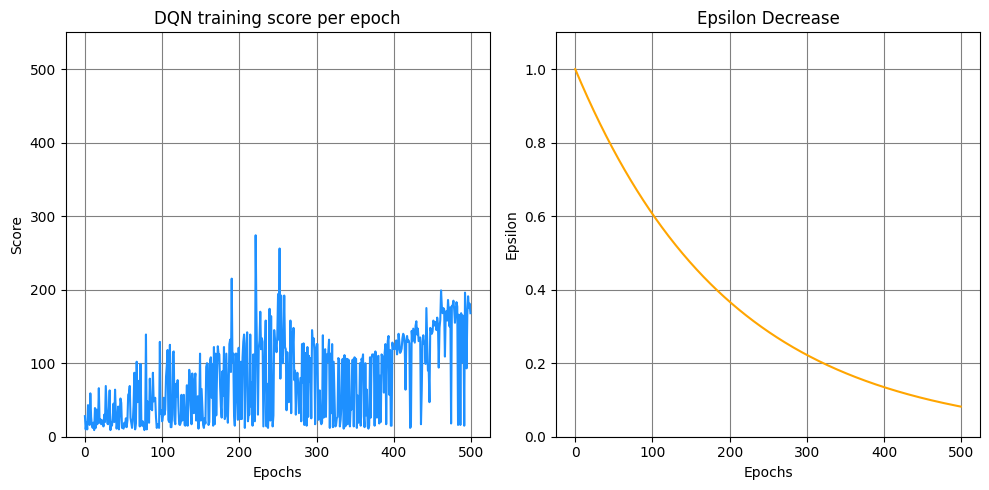

In [29]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].plot(results['scores'], color='dodgerblue')
axis[0].set_ylim(0, 550)
axis[0].set_title("DQN training score per epoch")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Score")
axis[0].grid(color='grey')

axis[1].plot(results['epsilons'], color='orange')
axis[1].set_title("Epsilon Decrease")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Epsilon")
axis[1].set_ylim(0, 1.1)
axis[1].grid(color='grey')

plt.tight_layout()
plt.savefig(plots_save_path + 'dqn_training_results.png')
plt.show()

### Testing the trained model and compare the results

In [30]:
# Load the trained model for testing
model = T.load('../models/dqn_model.pth')
agent.policy_network.load_state_dict(model)
agent.policy_network.eval()

# Testing the trained model
test_epochs = 200
test_epochs_scores = []
wins, fails = 0, 0

set_seed(42)

env = gym.make('CartPole-v1')
for epoch in range(1, test_epochs+1):
    observation, info = env.reset(seed=42 if epoch == 1 else None)
    done = False
    score, total_steps = 0, 0
    
    while not done:
        action = agent.choose_action(observation)
        observation, reward, terminated, truncated, _ = env.step(action)
        score += reward
        total_steps += 1
        
        if terminated or truncated:
            observation, _ = env.reset(seed=42 if epoch == 1 else None)
            done = True

            if terminated and total_steps < test_epochs:
                fails += 1
            else:
                wins +=1
    
    test_epochs_scores.append(score)

env.close()

dqn_scores = test_epochs_scores
dqn_wins, dqn_fails = wins, fails

C:\Users\Antonis\AppData\Local\Temp\ipykernel_7160\1968784890.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = T.load('../models/dqn_model.pth')


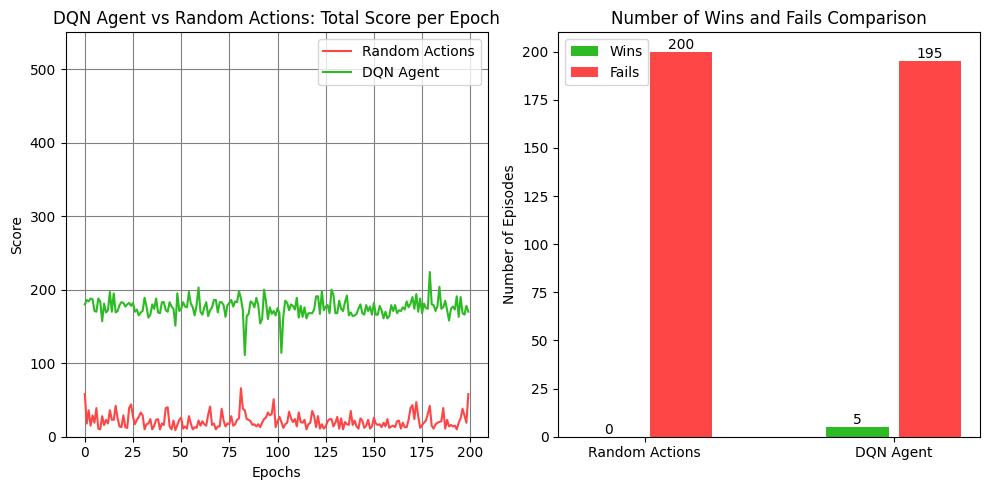

Number of wins with DQN Agent: 5
Number of fails with DQN Agent: 195


In [31]:
# Comparing the results between random actions and DQN agent
figure, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].plot(default_scores, label='Random Actions', color='#FF4646')
axis[0].plot(test_epochs_scores, label='DQN Agent', color='#2DBB23')

axis[0].set_ylim(0, 550)
axis[0].set_title("DQN Agent vs Random Actions: Total Score per Epoch")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Score")
axis[0].legend()
axis[0].grid(color='grey')

categories = ['Random Actions', 'DQN Agent']
x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars
gap = 0.02

wins_values = [default_wins, dqn_wins]
fails_values = [default_fails, dqn_fails]

bars_wins = axis[1].bar(x - width/2 - gap, wins_values, width, label='Wins', color=["#2DBB23", '#2DBB23'])
bars_fails = axis[1].bar(x + width/2 + gap, fails_values, width, label='Fails', color=['#FF4646', '#FF4646'])

axis[1].set_title("Number of Wins and Fails Comparison")
axis[1].set_ylabel("Number of Episodes")
axis[1].set_xticks(x)
axis[1].set_xticklabels(categories)
axis[1].legend()

# Adding labels on top of the bars
for bar in bars_wins:
    height = bar.get_height()
    axis[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

for bar in bars_fails:
    height = bar.get_height()
    axis[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(plots_save_path + 'dqn_vs_random.png')
plt.show()

print(f'Number of wins with DQN Agent: {dqn_wins}')
print(f'Number of fails with DQN Agent: {dqn_fails}')

### Sensitivity Study

1. Learning Rate ($\alpha$)
2. Discount Factor ($\gamma$)
3. Replay Buffer Size
4. Batch Size

In [35]:
def run_sensitivity_study(experiments_params=None, network=DeepQNetwork_CartPole):
    results = {}

    for param, values in experiments_params.items():
        
        results[param] = {}
        print(f"\n--- Sensitivity Study: Varying {param} ---")

        for value in values:
            print(f"Running experiment with {param} = {value}")
            if param == "lr":
                agent = Agent(
                    gamma=0.99, epsilon=1.0, lr=value, input_dims=4, n_actions=2,
                    epsilon_min=EPSILON_END, epsilon_decay=EPSILON_DECAY, taget_update_freq=TARGET_UPDATE,
                    memory_size=MEMORY_SIZE, batch_size=BATCH_SIZE, network=network, device=device                
                )
            elif param == "gamma":
                agent = Agent(
                    gamma=value, epsilon=1.0, lr=0.001, input_dims=4, n_actions=2,
                    epsilon_min=EPSILON_END, epsilon_decay=EPSILON_DECAY, taget_update_freq=TARGET_UPDATE,
                    memory_size=MEMORY_SIZE, batch_size=BATCH_SIZE, network=network, device=device                
                )
            elif param == "replay_buffer_size":
                agent = Agent(
                    gamma=0.99, epsilon=1.0, lr=0.001, input_dims=4, n_actions=2,
                    epsilon_min=EPSILON_END, epsilon_decay=EPSILON_DECAY, taget_update_freq=TARGET_UPDATE,
                    memory_size=value, batch_size=BATCH_SIZE, network=network, device=device                
                )
                agent.memory_size = value
                agent.memory_buffer = ReplayBufferMemory(capacity=value, device=device)
            elif param == "batch_size":
                agent = Agent(
                    gamma=0.99, epsilon=1.0, lr=0.001, input_dims=4, n_actions=2,
                    epsilon_min=EPSILON_END, epsilon_decay=EPSILON_DECAY, taget_update_freq=TARGET_UPDATE,
                    memory_size=MEMORY_SIZE, batch_size=value, network=network, device=device                
                )
                agent.batch_size = value

            trainer = Trainer(agent, env)
            results[param][value] = trainer.train_agent(num_episodes=100, printing=False)
    
    return results

In [36]:
experiments_params = {
    "lr": [1e-4, 5e-4, 1e-3, 5e-3],
    "gamma": [0.8, 0.9, 0.99, 0.999],
    "replay_buffer_size": [1000, 5000, 10000, 50000],
    "batch_size": [32, 64, 128, 256]
}

sensitivity_study_results = run_sensitivity_study(experiments_params, DeepQNetwork_CartPole)


--- Sensitivity Study: Varying lr ---
Running experiment with lr = 0.0001
Running experiment with lr = 0.0005
Running experiment with lr = 0.001
Running experiment with lr = 0.005

--- Sensitivity Study: Varying gamma ---
Running experiment with gamma = 0.8
Running experiment with gamma = 0.9
Running experiment with gamma = 0.99
Running experiment with gamma = 0.999

--- Sensitivity Study: Varying replay_buffer_size ---
Running experiment with replay_buffer_size = 1000
Running experiment with replay_buffer_size = 5000
Running experiment with replay_buffer_size = 10000
Running experiment with replay_buffer_size = 50000

--- Sensitivity Study: Varying batch_size ---
Running experiment with batch_size = 32
Running experiment with batch_size = 64
Running experiment with batch_size = 128
Running experiment with batch_size = 256


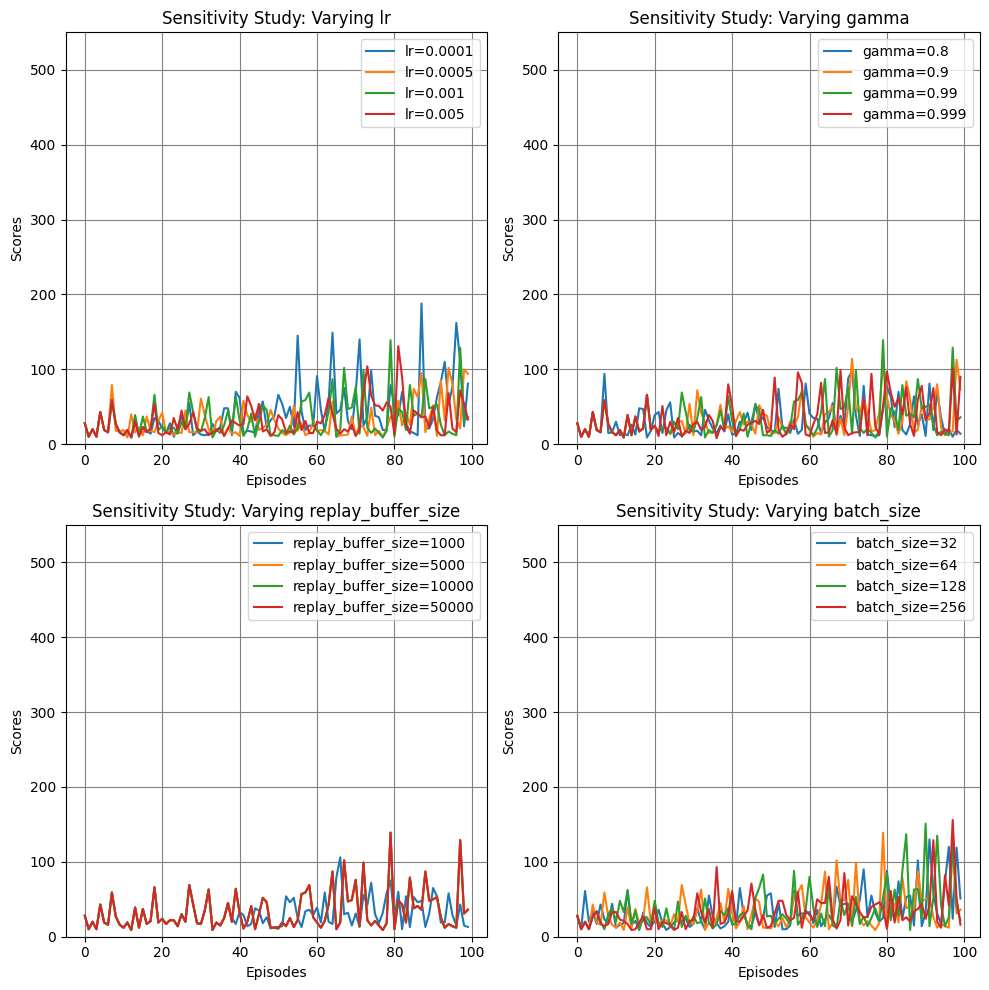

In [37]:
# Plot the sensitivity study results in a grid of 8x2
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for idx, (param, experiments) in enumerate(sensitivity_study_results.items()):
    for value, result in experiments.items():
        axes[idx].plot(result['scores'], label=f'{param}={value}')
    
    axes[idx].set_title(f'Sensitivity Study: Varying {param}')
    axes[idx].set_xlabel('Episodes')
    axes[idx].set_ylabel('Scores')
    axes[idx].set_ylim(0, 550)
    axes[idx].legend()
    axes[idx].grid(color='grey')

# Hide any unused subplots
for i in range(len(sensitivity_study_results), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(plots_save_path + 'dqn_sensitivity_study.png')
plt.show()

### Dueling Architecture

In [38]:
class DuelingArchitectureNetwork(nn.Module):
    def __init__(self, input_dims: int, output_dims: int) -> None:
        super(DuelingArchitectureNetwork, self).__init__()
        self.input_dims = input_dims
        self.output_dims = output_dims

        self.fc1 = nn.Linear(self.input_dims, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)

        # Value and Advantage streams
        self.value_stream_fc = nn.Linear(128, 64)
        self.value_stream = nn.Linear(64, 1)

        self.advantage_stream_fc = nn.Linear(128, 64)
        self.advantage_stream = nn.Linear(64, self.output_dims)
          

    def forward(self, state: T.Tensor) -> T.Tensor:
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        v = F.relu(self.value_stream_fc(x))
        v = self.value_stream(v)

        a = F.relu(self.advantage_stream_fc(x))
        a = self.advantage_stream(a)

        actions = v + (a - a.mean(dim=1, keepdim=True))

        return actions


In [39]:
agent = Agent(
    GAMMA, EPSILON_START, EPSILON_END, EPSILON_DECAY, LR, observations, actions, TARGET_UPDATE, 
    MEMORY_SIZE, BATCH_SIZE, DuelingArchitectureNetwork, device
)
trainer = Trainer(agent, env)

results = trainer.train_agent(500)

env.close()

# Save the trained model
T.save(agent.policy_network.state_dict(), '../models/dueling_arc_dqn_model.pth')

Episode 1: Score: 28.0, Epsilon: 0.99
Episode 50:  Score: 19.0, Epsilon: 0.77
Episode 100:  Score: 13.0, Epsilon: 0.60
Episode 150:  Score: 34.0, Epsilon: 0.47
Episode 200:  Score: 44.0, Epsilon: 0.37
Episode 250:  Score: 283.0, Epsilon: 0.28
Episode 300:  Score: 349.0, Epsilon: 0.22
Episode 350:  Score: 11.0, Epsilon: 0.17
Episode 400:  Score: 39.0, Epsilon: 0.13
Episode 450:  Score: 187.0, Epsilon: 0.10
Episode 500: Score: 242.0, Epsilon: 0.08


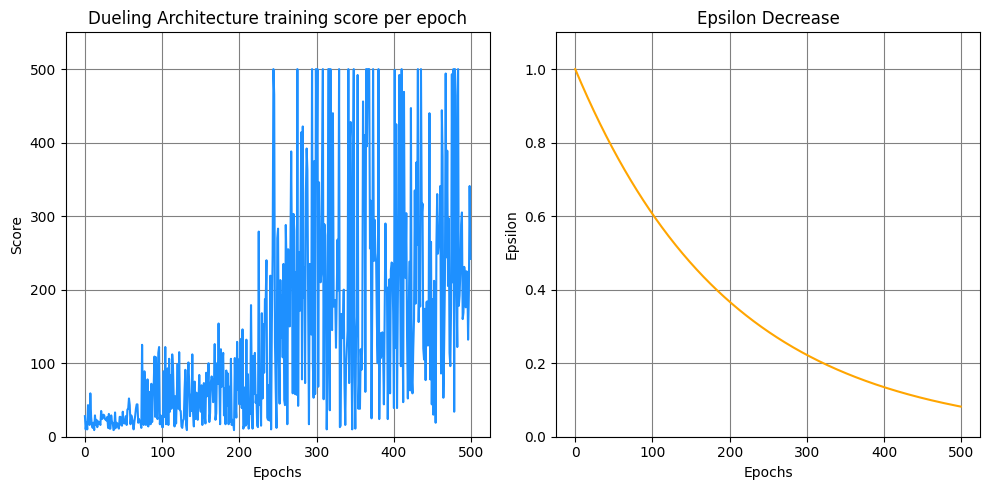

In [ ]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].plot(results['scores'], color='dodgerblue')
axis[0].set_ylim(0, 550)
axis[0].set_title("Dueling Architecture training score per epoch")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Score")
axis[0].grid(color='grey')

axis[1].plot(results['epsilons'], color='orange')
axis[1].set_title("Epsilon Decrease")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Epsilon")
axis[1].set_ylim(0, 1.1)
axis[1].grid(color='grey')

plt.tight_layout()
plt.savefig(plots_save_path + 'dueling_training_results.png')
plt.show()

In [41]:
# Load the trained model for testing
model = T.load('../models/dueling_arc_dqn_model.pth')
agent.policy_network.load_state_dict(model)
agent.policy_network.eval()

# Testing the trained model
test_epochs = 200
test_epochs_scores = []
wins, fails = 0, 0

set_seed(42)

env = gym.make('CartPole-v1')
for epoch in range(1, test_epochs+1):
    env.reset(seed=42 if epoch == 1 else None)
    done = False
    score, total_steps = 0, 0
    
    while not done:
        action = agent.choose_action(observation)
        observation, reward, terminated, truncated, _ = env.step(action)
        score += reward
        total_steps += 1
        
        if terminated or truncated:
            observation, _ = env.reset(seed=42 if epoch == 1 else None)
            done = True

            if terminated and total_steps < test_epochs:
                fails += 1
            else:
                wins +=1
    
    test_epochs_scores.append(score)

env.close()

dqn_scores = test_epochs_scores
dqn_wins, dqn_fails = wins, fails

C:\Users\Antonis\AppData\Local\Temp\ipykernel_7160\2040070741.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = T.load('../models/dueling_arc_dqn_model.pth')


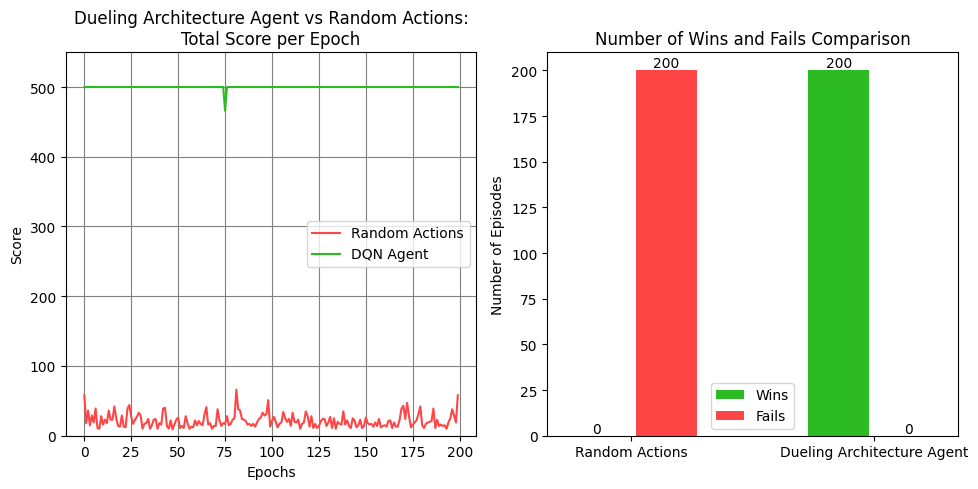

Number of wins with DQN Agent: 200
Number of fails with DQN Agent: 0


In [ ]:
# Comparing the results between random actions and DQN agent
figure, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].plot(default_scores, label='Random Actions', color='#FF4646')
axis[0].plot(test_epochs_scores, label='DQN Agent', color='#2DBB23')

axis[0].set_ylim(0, 550)
axis[0].set_title("Dueling Architecture Agent vs Random Actions:\nTotal Score per Epoch")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Score")
axis[0].legend()
axis[0].grid(color='grey')

categories = ['Random Actions', 'Dueling Architecture Agent']
x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars
gap = 0.02

wins_values = [default_wins, dqn_wins]
fails_values = [default_fails, dqn_fails]

bars_wins = axis[1].bar(x - width/2 - gap, wins_values, width, label='Wins', color=["#2DBB23", '#2DBB23'])
bars_fails = axis[1].bar(x + width/2 + gap, fails_values, width, label='Fails', color=['#FF4646', '#FF4646'])

axis[1].set_title("Number of Wins and Fails Comparison")
axis[1].set_ylabel("Number of Episodes")
axis[1].set_xticks(x)
axis[1].set_xticklabels(categories)
axis[1].legend()

# Adding labels on top of the bars
for bar in bars_wins:
    height = bar.get_height()
    axis[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

for bar in bars_fails:
    height = bar.get_height()
    axis[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(plots_save_path + 'dueling_vs_random.png')
plt.show()

print(f'Number of wins with Dueling Agent: {dqn_wins}')
print(f'Number of fails with Dueling Agent: {dqn_fails}')

In [43]:
sensitivity_study_results = run_sensitivity_study(experiments_params, DuelingArchitectureNetwork)


--- Sensitivity Study: Varying lr ---
Running experiment with lr = 0.0001
Running experiment with lr = 0.0005
Running experiment with lr = 0.001
Running experiment with lr = 0.005

--- Sensitivity Study: Varying gamma ---
Running experiment with gamma = 0.8
Running experiment with gamma = 0.9
Running experiment with gamma = 0.99
Running experiment with gamma = 0.999

--- Sensitivity Study: Varying replay_buffer_size ---
Running experiment with replay_buffer_size = 1000
Running experiment with replay_buffer_size = 5000
Running experiment with replay_buffer_size = 10000
Running experiment with replay_buffer_size = 50000

--- Sensitivity Study: Varying batch_size ---
Running experiment with batch_size = 32
Running experiment with batch_size = 64
Running experiment with batch_size = 128
Running experiment with batch_size = 256


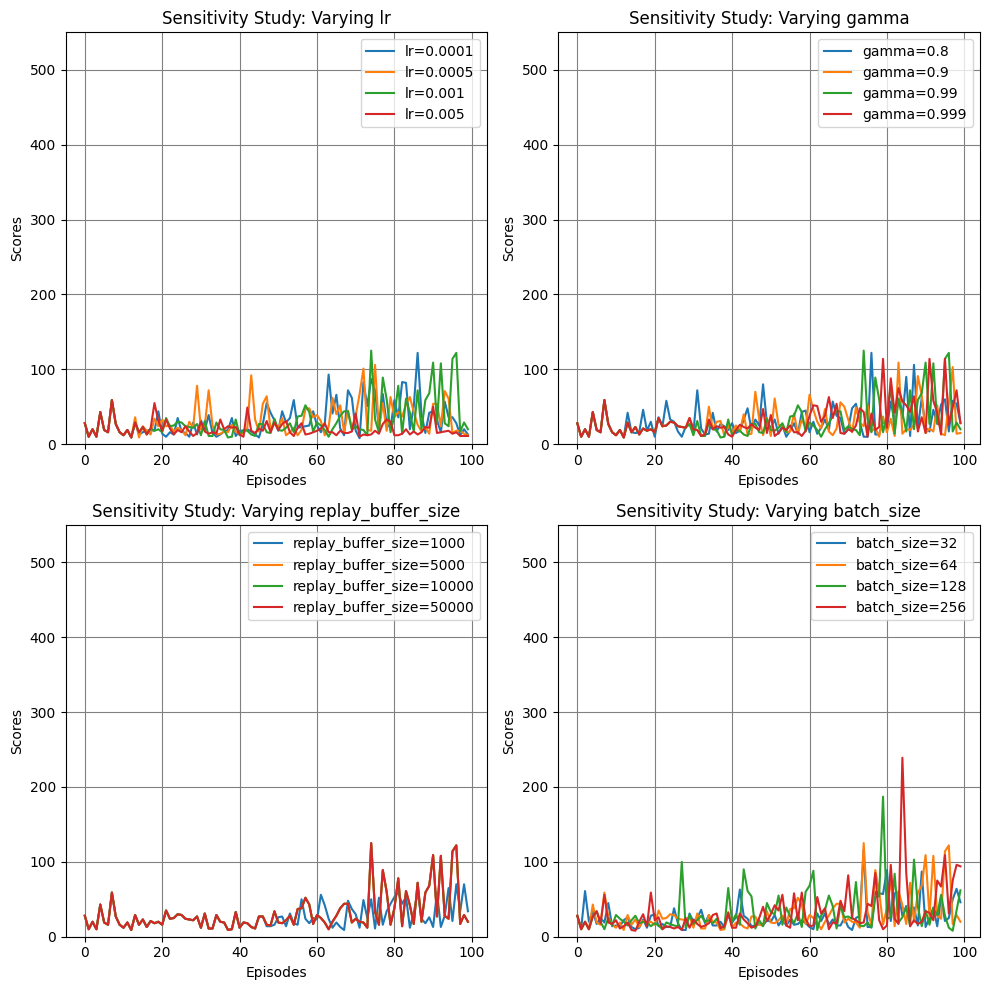

In [44]:
# Plot the sensitivity study results in a grid of 8x2
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for idx, (param, experiments) in enumerate(sensitivity_study_results.items()):
    for value, result in experiments.items():
        axes[idx].plot(result['scores'], label=f'{param}={value}')
    
    axes[idx].set_title(f'Sensitivity Study: Varying {param}')
    axes[idx].set_xlabel('Episodes')
    axes[idx].set_ylabel('Scores')
    axes[idx].set_ylim(0, 550)
    axes[idx].legend()
    axes[idx].grid(color='grey')

# Hide any unused subplots
for i in range(len(sensitivity_study_results), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(plots_save_path + 'dueling_architecture_sensitivity_study.png')
plt.show()

### Transformers

In [45]:
from torch import nn, Tensor
import torch as T
import numpy as np

class TransformerQNetwork(nn.Module):
    def __init__(self, seq_len=10, d_model=64, nhead=4, num_layers=2):
        super(TransformerQNetwork, self).__init__()

        self.seq_len = seq_len
        self.d_model = d_model
        self.nhead = nhead

        self.embedding = nn.Linear(4, d_model)
        self.positional_encoding = nn.Parameter(T.zeros(1, seq_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(d_model, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.positional_encoding[:, :x.size(1), :]
        x = self.transformer(x)
        x = x[:, -1, :]  # Use the output of the last time step
        q_values = self.fc_out(x)
        
        return q_values

In [46]:
class SequenceReplayBuffer:
    def __init__(self, capacity=10000, state_dim=4, seq_len=10, device='cpu'):
        self.device = device
        self.capacity = capacity
        self.seq_len = seq_len
        self.state_dim = state_dim

        self.states = T.zeros((self.capacity, self.state_dim), dtype=T.float32)
        self.actions = T.zeros((self.capacity,), dtype=T.int64)
        self.rewards = T.zeros((self.capacity,), dtype=T.float32)
        self.next_states = T.zeros((self.capacity, self.state_dim), dtype=T.float32)
        self.dones = T.zeros((self.capacity,), dtype=T.float32)

        self.position = 0
        self.size = 0

    def push(self, state, action, reward, next_state, done):
        self.states[self.position] = T.tensor(state, dtype=T.float32)
        self.actions[self.position] = T.tensor(action, dtype=T.int64)
        self.rewards[self.position] = T.tensor(reward, dtype=T.float32)
        self.next_states[self.position] = T.tensor(next_state, dtype=T.float32)
        self.dones[self.position] = T.tensor(done, dtype=T.float32)

        self.position = (self.position + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        indeces = []
        while len(indeces) < batch_size:
            idx = np.random.randint(self.seq_len, self.size - 2)
            indeces.append(idx)

        state_seqs, action_batch, reward_batch, next_state_seqs, done_batch = [], [], [], [], []

        for idx in indeces:
            state_seq = self.states[idx - self.seq_len + 1 : idx + 1]
            next_state_seq = self.next_states[idx - self.seq_len + 2 : idx + 2]

            state_seqs.append(state_seq.unsqueeze(0))
            next_state_seqs.append(next_state_seq.unsqueeze(0))
            action_batch.append(self.actions[idx].unsqueeze(0))
            reward_batch.append(self.rewards[idx].unsqueeze(0))
            done_batch.append(self.dones[idx].unsqueeze(0))

        state_seqs = T.tensor(np.array(state_seqs), dtype=T.float32).squeeze(1).to(self.device)
        next_state_seqs = T.tensor(np.array(next_state_seqs), dtype=T.float32).squeeze(1).to(self.device)
        action_batch = T.tensor(np.array(action_batch), dtype=T.int64).squeeze(1).to(self.device)
        reward_batch = T.tensor(np.array(reward_batch), dtype=T.float32).squeeze(1).to(self.device)
        done_batch = T.tensor(np.array(done_batch), dtype=T.float32).squeeze(1).to(self.device)

        return state_seqs, action_batch, reward_batch, next_state_seqs, done_batch
    
    def __len__(self):
        return self.size

In [47]:
import torch as T
import torch.nn as nn
import numpy as np


class TransformerAgent():
    def __init__(
            self, gamma, epsilon, epsilon_min, epsilon_decay, lr, input_dims, n_actions, taget_update_freq, 
            memory_size, batch_size, seq_len, device
        ):
        self.gamma = gamma
        self.seq_len = seq_len

        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.input_dims = input_dims
        self.n_actions = n_actions
        self.device = device

        self.action_space = [i for i in range(n_actions)]
        self.batch_size = batch_size
        self.target_update_freq = taget_update_freq
        self.memory_size = memory_size

        # Initialize the Deep Q-Networks and send to device
        self.policy_network = TransformerQNetwork(seq_len=self.seq_len).to(self.device)
        self.target_network = TransformerQNetwork(seq_len=self.seq_len).to(self.device)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.target_network.eval()

        self.learning_rate = lr
        self.optimizer = T.optim.Adam(self.policy_network.parameters(), lr=self.learning_rate)
        self.memory_buffer = SequenceReplayBuffer(capacity=self.memory_size, seq_len=self.seq_len, device=self.device)

        self.steps_done = 0  # Track total steps globally

    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_space)
        else:
            state = T.tensor(np.array([observation] * self.seq_len), dtype=T.float32).to(self.device)
            with T.no_grad():
                actions = self.policy_network(state)
            best_action = T.argmax(actions, dim=1).item()
            return best_action

    def optimize(self):
        if len(self.memory_buffer) <= self.batch_size + self.seq_len:
            return

        # Sample batch from replay buffer. Batch tensors are already on the appropriate device via ReplayBufferMemory.sample
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory_buffer.sample(self.batch_size)

        # Compute current Q values
        q_values = self.policy_network(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze(1)

        # Compute target Q values using target network
        with T.no_grad():
            max_next_q_values = self.target_network(next_state_batch).max(1)[0]
            target_q_values = reward_batch + self.gamma * max_next_q_values * (1 - done_batch)

        # Calculate loss
        loss = nn.MSELoss()(q_values, target_q_values.detach())

        # Optimize model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


In [48]:
import numpy as np

class TransformerTrainer():
    def __init__(self, agent, env):
        self.agent = agent
        self.env = env

    def train_agent(self, num_episodes=100, seed=42, printing=True):
        set_seed(seed)

        score_per_episode = []
        loss_per_episode = []
        epsilon_per_episode = []

        for episode in range(num_episodes):
            observation = self.env.reset(seed=42)[0]
            episode_score, episode_loss = 0, 0
            done = False

            while not done:
                action = self.agent.choose_action(observation)
                next_observation, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated

                self.agent.memory_buffer.push(observation, action, reward, next_observation, float(done))

                observation = next_observation
                episode_score += reward

                loss = self.agent.optimize()
                if loss is not None:
                    episode_loss += loss

                self.agent.steps_done += 1

            epsilon_per_episode.append(self.agent.epsilon)
            score_per_episode.append(episode_score)
            loss_per_episode.append(episode_loss)

            if episode % self.agent.target_update_freq == 0:
                self.agent.target_network.load_state_dict(self.agent.policy_network.state_dict())
                
            self.agent.decay_epsilon()

            # Logging progress every ~10% of total episodes
            if printing:
                if episode == 0 or episode == num_episodes - 1 or episode % max(1, num_episodes // 10) == 0:
                    if episode == 0 or episode == num_episodes - 1: print(f'Episode {episode+1}:', end=' ')
                    else: print(f'Episode {episode}: ', end=' ')
                    print(f"Score: {episode_score}, Epsilon: {self.agent.epsilon:.2f}")

        return {
            "scores": score_per_episode, 
            "losses": loss_per_episode, 
            "epsilons": epsilon_per_episode
        }


In [49]:
# Hyperparameters
GAMMA = 0.99          # Discount factor
LR = 1e-3             # Learning rate
BATCH_SIZE = 64       # Minibatch size
MEMORY_SIZE = 10000   # Replay buffer size
EPSILON_START = 1.0   # Starting exploration probability
EPSILON_END = 0.01    # Minimum exploration probability
EPSILON_DECAY = 0.995 # Epsilon decay rate
TARGET_UPDATE = 10    # How often to update the target network

In [50]:
agent = TransformerAgent(
    GAMMA, EPSILON_START, EPSILON_END, EPSILON_DECAY, LR, observations, actions, TARGET_UPDATE, 
    MEMORY_SIZE, BATCH_SIZE, seq_len=10, device=device
)
trainer = TransformerTrainer(agent, env)

results = trainer.train_agent(500)

env.close()

# Save the trained model
T.save(agent.policy_network.state_dict(), '../models/transformer_model.pth')

Episode 1: Score: 28.0, Epsilon: 0.99
Episode 50:  Score: 12.0, Epsilon: 0.77
Episode 100:  Score: 24.0, Epsilon: 0.60
Episode 150:  Score: 66.0, Epsilon: 0.47
Episode 200:  Score: 143.0, Epsilon: 0.37
Episode 250:  Score: 79.0, Epsilon: 0.28
Episode 300:  Score: 345.0, Epsilon: 0.22
Episode 350:  Score: 181.0, Epsilon: 0.17
Episode 400:  Score: 307.0, Epsilon: 0.13
Episode 450:  Score: 148.0, Epsilon: 0.10
Episode 500: Score: 266.0, Epsilon: 0.08


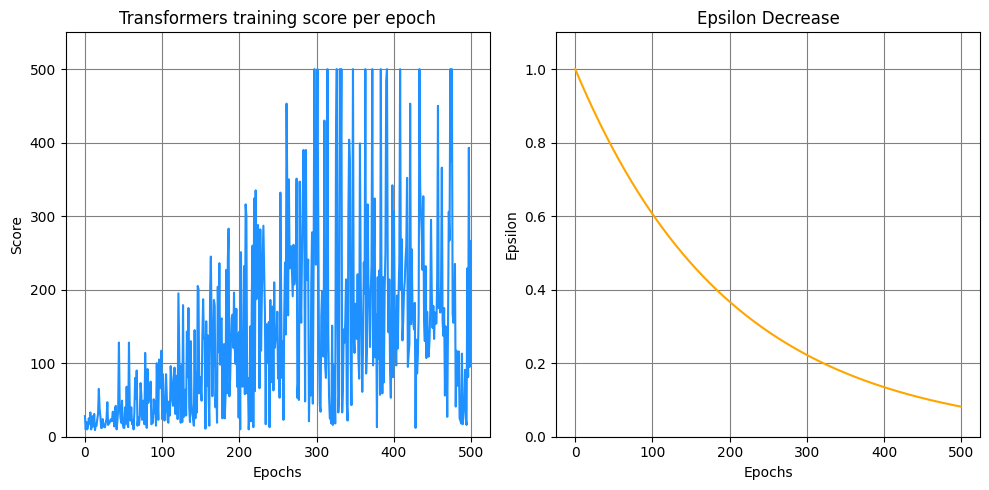

In [ ]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].plot(results['scores'], color='dodgerblue')
axis[0].set_ylim(0, 550)
axis[0].set_title("Transformers training score per epoch")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Score")
axis[0].grid(color='grey')

axis[1].plot(results['epsilons'], color='orange')
axis[1].set_title("Epsilon Decrease")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Epsilon")
axis[1].set_ylim(0, 1.1)
axis[1].grid(color='grey')

plt.tight_layout()
plt.savefig(plots_save_path + 'transformer_training_results.png')
plt.show()

In [52]:
# Load the trained model for testing
model = T.load('../models/transformer_model.pth')
agent.policy_network.load_state_dict(model)
agent.policy_network.eval()

# Testing the trained model
test_epochs = 200
test_epochs_scores = []
wins, fails = 0, 0

set_seed(42)

env = gym.make('CartPole-v1')
for epoch in range(1, test_epochs+1):
    env.reset(seed=42 if epoch == 1 else None)
    done = False
    score, total_steps = 0, 0
    
    while not done:
        action = agent.choose_action(observation)
        observation, reward, terminated, truncated, _ = env.step(action)
        score += reward
        total_steps += 1
        
        if terminated or truncated:
            observation, _ = env.reset(seed=42 if epoch == 1 else None)
            done = True

            if terminated and total_steps < test_epochs:
                fails += 1
            else:
                wins +=1
    
    test_epochs_scores.append(score)

env.close()

dqn_scores = test_epochs_scores
dqn_wins, dqn_fails = wins, fails

C:\Users\Antonis\AppData\Local\Temp\ipykernel_7160\1130159581.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = T.load('../models/transformer_model.pth')


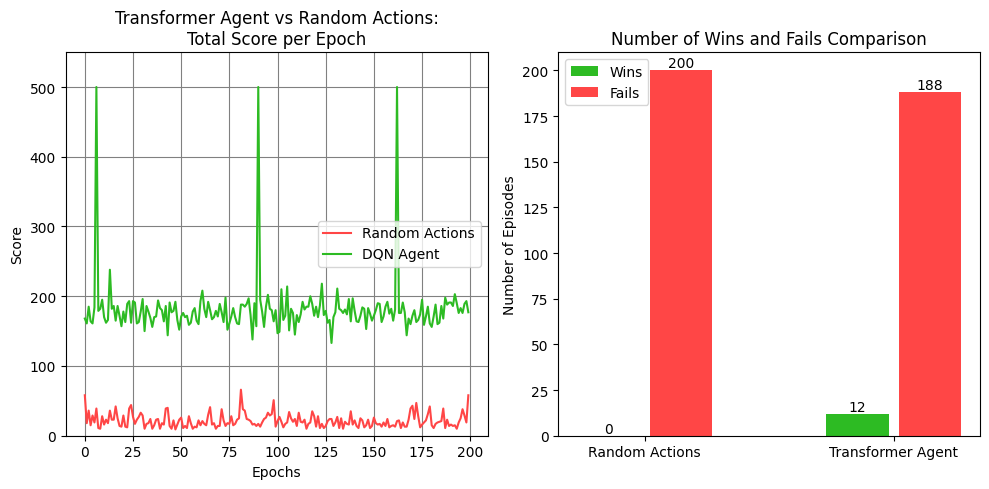

Number of wins with Transformer Agent: 12
Number of fails with Transformer Agent: 188


In [ ]:
# Comparing the results between random actions and DQN agent
figure, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].plot(default_scores, label='Random Actions', color='#FF4646')
axis[0].plot(test_epochs_scores, label='DQN Agent', color='#2DBB23')

axis[0].set_ylim(0, 550)
axis[0].set_title("Transformer Agent vs Random Actions:\nTotal Score per Epoch")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Score")
axis[0].legend()
axis[0].grid(color='grey')

categories = ['Random Actions', 'Transformer Agent']
x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars
gap = 0.02

wins_values = [default_wins, dqn_wins]
fails_values = [default_fails, dqn_fails]

bars_wins = axis[1].bar(x - width/2 - gap, wins_values, width, label='Wins', color=["#2DBB23", '#2DBB23'])
bars_fails = axis[1].bar(x + width/2 + gap, fails_values, width, label='Fails', color=['#FF4646', '#FF4646'])

axis[1].set_title("Number of Wins and Fails Comparison")
axis[1].set_ylabel("Number of Episodes")
axis[1].set_xticks(x)
axis[1].set_xticklabels(categories)
axis[1].legend()

# Adding labels on top of the bars
for bar in bars_wins:
    height = bar.get_height()
    axis[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

for bar in bars_fails:
    height = bar.get_height()
    axis[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(plots_save_path + 'transformer_vs_random.png')
plt.show()

print(f'Number of wins with Transformer Agent: {dqn_wins}')
print(f'Number of fails with Transformer Agent: {dqn_fails}')

In [54]:
def run_transformer_sensitivity_study(experiments_params=None):
    results = {}

    for param, values in experiments_params.items():
        
        results[param] = {}
        print(f"\n--- Transformer Sensitivity Study: Varying {param} ---")

        for value in values:
            print(f"Running experiment with {param} = {value}")
            if param == "lr":
                agent = TransformerAgent(
                    gamma=0.99, epsilon=1.0, lr=value, input_dims=4, n_actions=2,
                    epsilon_min=EPSILON_END, epsilon_decay=EPSILON_DECAY, taget_update_freq=TARGET_UPDATE,
                    memory_size=MEMORY_SIZE, batch_size=BATCH_SIZE, seq_len=5, device=device                
                )
            elif param == "gamma":
                agent = TransformerAgent(
                    gamma=value, epsilon=1.0, lr=0.001, input_dims=4, n_actions=2,
                    epsilon_min=EPSILON_END, epsilon_decay=EPSILON_DECAY, taget_update_freq=TARGET_UPDATE,
                    memory_size=MEMORY_SIZE, batch_size=BATCH_SIZE, seq_len=5, device=device                
                )
            elif param == "replay_buffer_size":
                agent = TransformerAgent(
                    gamma=0.99, epsilon=1.0, lr=0.001, input_dims=4, n_actions=2,
                    epsilon_min=EPSILON_END, epsilon_decay=EPSILON_DECAY, taget_update_freq=TARGET_UPDATE,
                    memory_size=value, batch_size=BATCH_SIZE, seq_len=5, device=device                
                )
                agent.memory_size = value
                agent.memory_buffer = ReplayBufferMemory(capacity=value, device=device)
            elif param == "seq_len":
                agent = TransformerAgent(
                    gamma=0.99, epsilon=1.0, lr=0.001, input_dims=4, n_actions=2,
                    epsilon_min=EPSILON_END, epsilon_decay=EPSILON_DECAY, taget_update_freq=TARGET_UPDATE,
                    memory_size=MEMORY_SIZE, batch_size=BATCH_SIZE, seq_len=value, device=device                
                )
                agent.seq_len = value

            trainer = TransformerTrainer(agent, env)
            results[param][value] = trainer.train_agent(num_episodes=100, printing=False)
    
    return results

In [55]:
experiments_params = {
    "lr": [1e-4, 5e-4, 1e-3, 5e-3],
    "gamma": [0.8, 0.9, 0.99, 0.999],
    "replay_buffer_size": [1000, 5000, 10000, 50000],
    "seq_len": [2, 5],
}

sensitivity_study_results = run_sensitivity_study(experiments_params)


--- Sensitivity Study: Varying lr ---
Running experiment with lr = 0.0001
Running experiment with lr = 0.0005
Running experiment with lr = 0.001
Running experiment with lr = 0.005

--- Sensitivity Study: Varying gamma ---
Running experiment with gamma = 0.8
Running experiment with gamma = 0.9
Running experiment with gamma = 0.99
Running experiment with gamma = 0.999

--- Sensitivity Study: Varying replay_buffer_size ---
Running experiment with replay_buffer_size = 1000
Running experiment with replay_buffer_size = 5000
Running experiment with replay_buffer_size = 10000
Running experiment with replay_buffer_size = 50000

--- Sensitivity Study: Varying seq_len ---
Running experiment with seq_len = 2
Running experiment with seq_len = 5


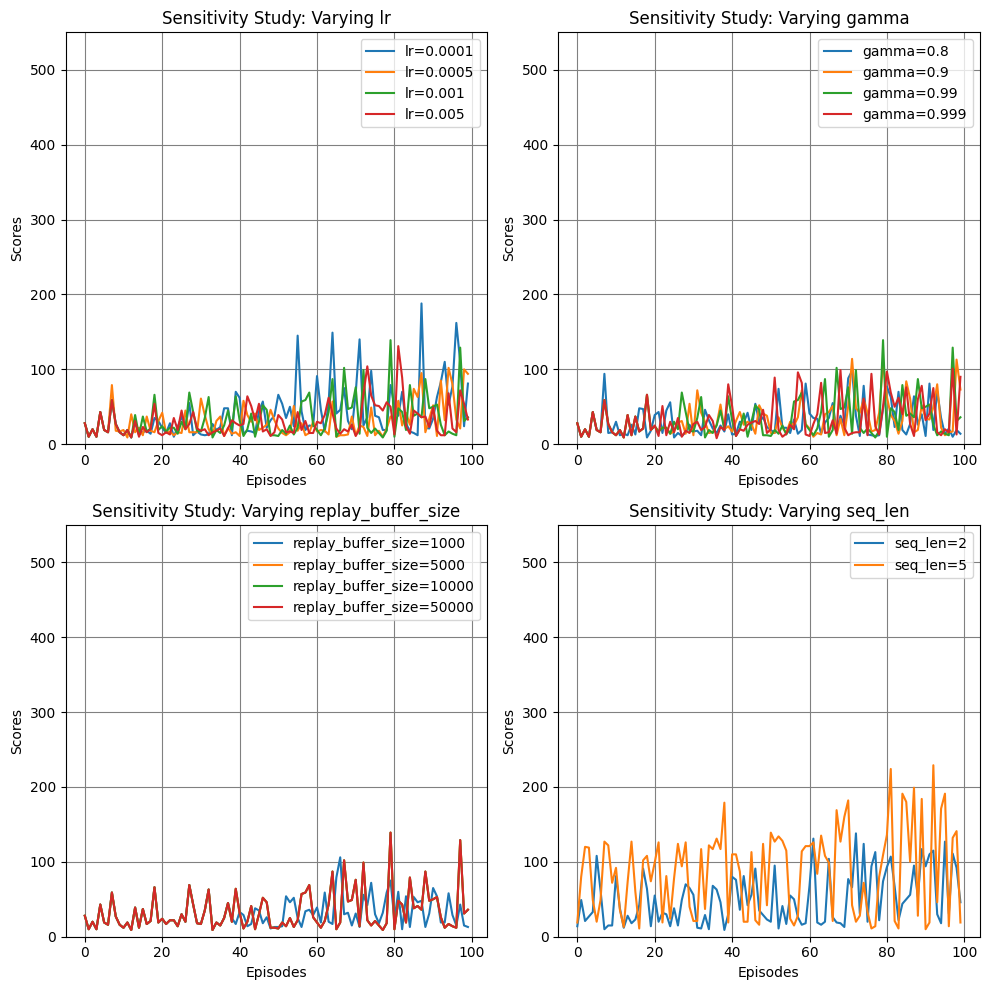

In [ ]:
# Plot the sensitivity study results in a grid of 8x2
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for idx, (param, experiments) in enumerate(sensitivity_study_results.items()):
    for value, result in experiments.items():
        axes[idx].plot(result['scores'], label=f'{param}={value}')
    
    axes[idx].set_title(f'Sensitivity Study: Varying {param}')
    axes[idx].set_xlabel('Episodes')
    axes[idx].set_ylabel('Scores')
    axes[idx].set_ylim(0, 550)
    axes[idx].legend()
    axes[idx].grid(color='grey')

# Hide any unused subplots
for i in range(len(sensitivity_study_results), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(plots_save_path + 'transformer_sensitivity_study.png')
plt.show()

# PPO & A2C Training

In [68]:
from stable_baselines3 import PPO

model = PPO('MlpPolicy', env, verbose=1, tensorboard_log="./tensorboard/")
TIMESTEPS = 10000

for i in range(1, 10):
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name="PPO")
    model.save(f'../models/ppo_{TIMESTEPS * i}.pth')

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboard/PPO_0


c:\Users\Antonis\anaconda3\envs\rl_assignment\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.7     |
|    ep_rew_mean     | 21.7     |
| time/              |          |
|    fps             | 386      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 26.9        |
|    ep_rew_mean          | 26.9        |
| time/                   |             |
|    fps                  | 317         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009294318 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | 0.00484     |
|    learning_rate        | 0.

In [64]:
from stable_baselines3.common.evaluation import evaluate_policy

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20, render=False)
print(f"Mean reward: {mean_reward} +/- {std_reward}")


c:\Users\Antonis\anaconda3\envs\rl_assignment\Lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: 500.0 +/- 0.0


In [69]:
from stable_baselines3 import A2C

model = A2C('MlpPolicy', env, verbose=1, tensorboard_log="./tensorboard/")
TIMESTEPS = 10000

for i in range(1, 10):
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name="A2C")
    model.save(f'../models/a2c_{TIMESTEPS * i}.pth')
    

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboard/A2C_0
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 49.2     |
|    ep_rew_mean        | 49.2     |
| time/                 |          |
|    fps                | 225      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.665   |
|    explained_variance | -0.307   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -1.76    |
|    value_loss         | 40.9     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 49.7     |
|    ep_rew_mean        | 49.7     |
| time/                 |          |
|    fps                | 236      |
|    iterations        

In [67]:
from stable_baselines3.common.evaluation import evaluate_policy

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20, render=False)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

Mean reward: 500.0 +/- 0.0
